<a href="https://colab.research.google.com/github/kevinmoreno1-ux/ENTREGAS/blob/main/03-modelo_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# logistic_regression_model.py
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Especificar las rutas a los archivos
train_file_path = '/content/drive/MyDrive/IA/SaberPro/train.csv'
test_file_path = '/content/drive/MyDrive/IA/SaberPro/test.csv'  # Asegúrate de que este archivo existe

print("=== MODELO REGRESIÓN LOGÍSTICA CON EVALUACIÓN DE ACCURACY ===")
print("=" * 70)

# ============================================================================
# PROCESAMIENTO DE DATOS
# ============================================================================

print("Cargando datos de entrenamiento...")
try:
    train_data = pd.read_csv(train_file_path)
    print(f"✓ Datos de entrenamiento cargados: {train_data.shape}")
except Exception as e:
    print(f"✗ Error cargando train.csv: {e}")
    raise

# Análisis de la variable objetivo
target_distribution = train_data['RENDIMIENTO_GLOBAL'].value_counts().sort_index()
print(f"✓ Distribución de RENDIMIENTO_GLOBAL:")
for class_val, count in target_distribution.items():
    percentage = (count / len(train_data)) * 100
    print(f"  - Clase {class_val}: {count} ({percentage:.1f}%)")

# Limpieza inicial
if 'F_TIENEINTERNET.1' in train_data.columns:
    train_data = train_data.drop(columns=["F_TIENEINTERNET.1"])

# Separar características numéricas y categóricas
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Excluir variable objetivo e ID
if 'RENDIMIENTO_GLOBAL' in numeric_cols:
    numeric_cols.remove('RENDIMIENTO_GLOBAL')
if 'RENDIMIENTO_GLOBAL' in categorical_cols:
    categorical_cols.remove('RENDIMIENTO_GLOBAL')
if 'ID' in numeric_cols:
    numeric_cols.remove('ID')
if 'ID' in categorical_cols:
    categorical_cols.remove('ID')

print(f"✓ Columnas numéricas: {len(numeric_cols)}")
print(f"✓ Columnas categóricas: {len(categorical_cols)}")

# Manejo de valores faltantes
print("Aplicando preprocesamiento...")
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

train_data[numeric_cols] = imputer_num.fit_transform(train_data[numeric_cols])
train_data[categorical_cols] = imputer_cat.fit_transform(train_data[categorical_cols])

# Codificación de variables categóricas
label_encoders = {}
for col in categorical_cols:
    try:
        le = LabelEncoder()
        train_data[col] = le.fit_transform(train_data[col].astype(str))
        label_encoders[col] = le
    except Exception as e:
        print(f"Error codificando {col}: {e}")
        train_data = train_data.drop(columns=[col])
        if col in categorical_cols:
            categorical_cols.remove(col)

# Preparar datos para entrenamiento
X_train = train_data.drop(columns=["RENDIMIENTO_GLOBAL", "ID"])
y_train = train_data["RENDIMIENTO_GLOBAL"]

# REGRESIÓN LOGÍSTICA REQUIERE ESCALADO
print("Aplicando escalado para Regresión Logística...")
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# ============================================================================
# EVALUACIÓN Y ENTRENAMIENTO REGRESIÓN LOGÍSTICA
# ============================================================================

print("\n=== EVALUACIÓN REGRESIÓN LOGÍSTICA ===")

# Probar diferentes configuraciones de regularización
lr_configs = [
    {'name': 'LR-L1', 'model': LogisticRegression(penalty='l1', C=0.1, solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000)},
    {'name': 'LR-L2', 'model': LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', class_weight='balanced', random_state=42, max_iter=1000)},
    {'name': 'LR-ElasticNet', 'model': LogisticRegression(penalty='elasticnet', C=0.1, solver='saga', l1_ratio=0.5, class_weight='balanced', random_state=42, max_iter=1000)}
]

best_score = 0
best_lr = None
best_config_name = ''

print("Evaluando diferentes configuraciones de Regresión Logística...")
for config in lr_configs:
    print(f"\nProbando {config['name']}...")
    model = config['model']

    # Validación cruzada para evaluación
    try:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
        mean_score = cv_scores.mean()
        std_score = cv_scores.std()

        print(f"  ✓ CV Accuracy: {mean_score:.4f} (+/- {std_score * 2:.4f})")

        if mean_score > best_score:
            best_score = mean_score
            best_lr = model
            best_config_name = config['name']

    except Exception as e:
        print(f"  ✗ Error en {config['name']}: {e}")

# Si todas fallan, usar configuración por defecto
if best_lr is None:
    print("Usando configuración por defecto...")
    best_lr = LogisticRegression(C=0.1, class_weight='balanced', random_state=42, max_iter=1000)
    best_config_name = 'LR-Default'
    cv_scores = cross_val_score(best_lr, X_train_scaled, y_train, cv=5, scoring='accuracy')
    best_score = cv_scores.mean()
    print(f"✓ CV Accuracy por defecto: {best_score:.4f}")

print(f"\n✓ MEJOR CONFIGURACIÓN: {best_config_name}")
print(f"✓ MEJOR ACCURACY (CV): {best_score:.4f}")

# Evaluación detallada del mejor modelo
print(f"\nEvaluación detallada de {best_config_name}...")
y_cv_pred = cross_val_predict(best_lr, X_train_scaled, y_train, cv=5)
cv_accuracy = accuracy_score(y_train, y_cv_pred)

print(f"✓ Accuracy con Validación Cruzada: {cv_accuracy:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_train, y_cv_pred)
print(f"✓ Matriz de Confusión (CV):")
for i, row in enumerate(cm):
    print(f"  Clase {i}: {row}")

# Entrenar el mejor modelo
print(f"\nEntrenando {best_config_name}...")
best_lr.fit(X_train_scaled, y_train)

# Accuracy en entrenamiento
y_train_pred = best_lr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"✓ Accuracy en Conjunto de Entrenamiento: {train_accuracy:.4f}")

# Reporte de clasificación
print(f"\n✓ Reporte de Clasificación:")
report = classification_report(y_train, y_train_pred, output_dict=True)
for class_label in sorted(report.keys()):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"  Clase {class_label}: Precision={report[class_label]['precision']:.3f}, "
              f"Recall={report[class_label]['recall']:.3f}, "
              f"F1={report[class_label]['f1-score']:.3f}")

print(f"  Accuracy Global: {report['accuracy']:.4f}")

print("✓ Modelo Regresión Logística entrenado y evaluado exitosamente")

# ============================================================================
# PROCESAMIENTO DE DATOS DE PRUEBA
# ============================================================================

print("\n" + "=" * 70)
print("PROCESAMIENTO DE DATOS DE PRUEBA")
print("=" * 70)

print("Cargando datos de prueba...")
try:
    test_data = pd.read_csv(test_file_path)
    print(f"✓ Datos de prueba cargados: {test_data.shape}")
except Exception as e:
    print(f"✗ Error cargando test.csv: {e}")
    raise

# Conservar IDs para la submission
test_ids = test_data['ID'].copy()

# Aplicar misma limpieza inicial
if 'F_TIENEINTERNET.1' in test_data.columns:
    test_data = test_data.drop(columns=["F_TIENEINTERNET.1"])

# Asegurar que las columnas coincidan con el entrenamiento
missing_cols = set(X_train.columns) - set(test_data.columns)
if missing_cols:
    print(f"✗ Columnas faltantes en test: {missing_cols}")
    raise ValueError("Faltan columnas en el conjunto de prueba")

extra_cols = set(test_data.columns) - set(X_train.columns) - {'ID'}
if extra_cols:
    print(f"⚠ Columnas adicionales en test: {extra_cols}")

# Reordenar columnas para coincidir con el entrenamiento
test_data = test_data[X_train.columns.tolist() + ['ID']]

# Aplicar imputación con los mismos parámetros de entrenamiento
test_data[numeric_cols] = imputer_num.transform(test_data[numeric_cols])
test_data[categorical_cols] = imputer_cat.transform(test_data[categorical_cols])

# Codificar variables categóricas con los mismos encoders
for col in categorical_cols:
    if col in label_encoders:
        unique_values = set(test_data[col].astype(str))
        unknown_values = unique_values - set(label_encoders[col].classes_)
        if unknown_values:
            print(f"⚠ Valores no vistos en {col}: {unknown_values}")
            most_frequent = label_encoders[col].classes_[0]
            test_data[col] = test_data[col].apply(
                lambda x: x if x in label_encoders[col].classes_ else most_frequent
            )
        test_data[col] = label_encoders[col].transform(test_data[col].astype(str))

# ESCALADO para Regresión Logística
X_test_scaled = test_data.drop(columns=['ID'])
X_test_scaled[numeric_cols] = scaler.transform(X_test_scaled[numeric_cols])

# ============================================================================
# PREDICCIÓN Y GENERACIÓN DE SUBMISSION
# ============================================================================

print("\nRealizando predicciones finales...")
y_pred = best_lr.predict(X_test_scaled)

# Usar probabilidades para ajustar casos borderline
y_proba = best_lr.predict_proba(X_test_scaled)

# Estrategia: ajustar predicciones con baja confianza
confidence_threshold = 0.6
y_pred_adjusted = y_pred.copy()

for i in range(len(y_proba)):
    max_proba = np.max(y_proba[i])
    if max_proba < confidence_threshold:
        # Si la confianza es baja, considerar la segunda mejor opción
        sorted_indices = np.argsort(y_proba[i])[::-1]
        if len(sorted_indices) > 1 and (y_proba[i][sorted_indices[0]] - y_proba[i][sorted_indices[1]] < 0.15):
            y_pred_adjusted[i] = sorted_indices[1]

# Verificar si el ajuste es significativo
changes = np.sum(y_pred != y_pred_adjusted)
if changes > 0:
    print(f"✓ Ajustados {changes} casos por baja confianza")
    y_pred_final = y_pred_adjusted
else:
    y_pred_final = y_pred

# Análisis de las predicciones
final_distribution = pd.Series(y_pred_final).value_counts().sort_index()
print(f"\n✓ Distribución de predicciones en TEST:")
for class_val, count in final_distribution.items():
    percentage = (count / len(y_pred_final)) * 100
    print(f"  - Clase {class_val}: {count} ({percentage:.1f}%)")

# Crear archivo de submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_pred_final
})

submission.to_csv(output_file_path, index=False)
print(f"✓ Archivo de submission guardado en: {output_file_path}")
print(f"✓ Total de predicciones: {len(y_pred_final)}")
print(f"✓ Configuración utilizada: {best_config_name}")

print("\n" + "=" * 70)
print("RESUMEN FINAL - REGRESIÓN LOGÍSTICA")
print("=" * 70)
print(f"Configuración:               {best_config_name}")
print(f"Accuracy Validación Cruzada: {cv_accuracy:.4f}")
print(f"Accuracy Entrenamiento:      {train_accuracy:.4f}")
print(f"Diferencia:                  {train_accuracy - cv_accuracy:.4f}")
print("=" * 70)

Mounted at /content/drive
=== MODELO REGRESIÓN LOGÍSTICA CON EVALUACIÓN DE ACCURACY ===
Cargando datos de entrenamiento...
✓ Datos de entrenamiento cargados: (692500, 21)
✓ Distribución de RENDIMIENTO_GLOBAL:
  - Clase alto: 175619 (25.4%)
  - Clase bajo: 172987 (25.0%)
  - Clase medio-alto: 171619 (24.8%)
  - Clase medio-bajo: 172275 (24.9%)
✓ Columnas numéricas: 5
✓ Columnas categóricas: 13
Aplicando preprocesamiento...
Aplicando escalado para Regresión Logística...

=== EVALUACIÓN REGRESIÓN LOGÍSTICA ===
Evaluando diferentes configuraciones de Regresión Logística...

Probando LR-L1...
  ✓ CV Accuracy: 0.3772 (+/- 0.0029)

Probando LR-L2...
  ✓ CV Accuracy: 0.3752 (+/- 0.0026)

Probando LR-ElasticNet...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== MODELO DE REGRESIÓN LOGÍSTICA MULTICLASE ===
✓ Dimensiones de train: (692500, 21)
✓ Dimensiones de test: (296786, 20)

📊 Columnas en train: 21
📊 Columnas en test: 20
✓ Columna duplicada 'F_TIENEINTERNET.1' eliminada
✓ Columna duplicada 'F_TIENEINTERNET.1' eliminada

🔢 Variables numéricas: 5
🔤 Variables categóricas: 13

🔄 Datos combinados para preprocesamiento: (989286, 19)
⏳ Procesando valores faltantes...
⏳ Codificando variables categóricas...

✅ Train procesado: (692500, 19)
✅ Test procesado: (296786, 19)

🎯 Clases codificadas: {0: 'alto', 1: 'bajo', 2: 'medio-alto', 3: 'medio-bajo'}

📈 X_train final: (692500, 18)
📈 X_test final: (296786, 18)
⏳ Escalando características...

=== DATOS PARA ENTRENAMIENTO Y VALIDACIÓN ===
🎯 Entrenamiento: (554000, 18)
🎯 Validación: (138500, 18)
🎯 Test real: (296786, 18)

=== ENTRENANDO MODELO DE REGRESIÓN LOGÍSTICA ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Modelo entrenado exitosamente

📊 RESULTADOS EN CONJUNTO DE VALIDACIÓN

🎯 Accuracy en Validación: 0.3741 (37.41%)

📋 Classification Report (Validación):
              precision    recall  f1-score   support

        alto       0.45      0.60      0.51     35124
        bajo       0.37      0.50      0.43     34597
  medio-alto       0.28      0.16      0.20     34324
  medio-bajo       0.31      0.23      0.26     34455

    accuracy                           0.37    138500
   macro avg       0.35      0.37      0.35    138500
weighted avg       0.35      0.37      0.35    138500



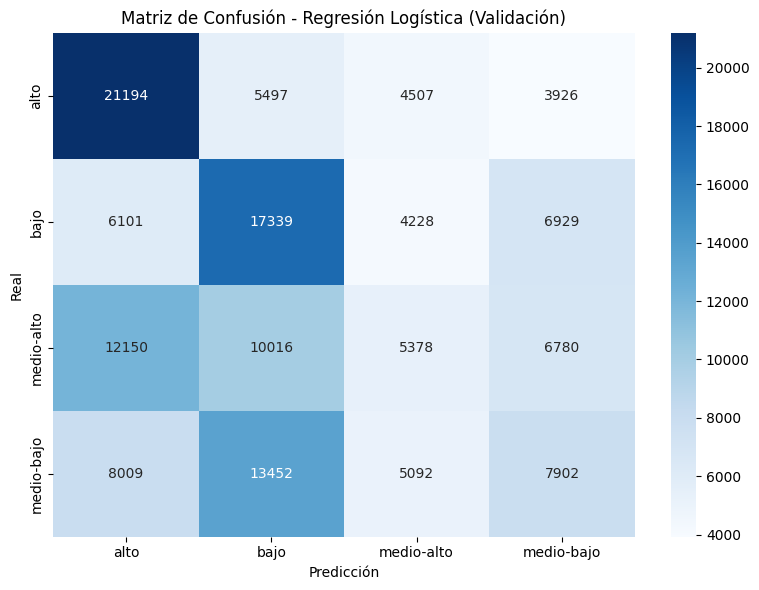


=== ENTRENANDO MODELO FINAL CON TODOS LOS DATOS DE TRAIN ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Modelo final entrenado

=== REALIZANDO PREDICCIONES EN TEST ===

=== CREANDO ARCHIVO SUBMISSION EN GOOGLE DRIVE ===

📊 Distribución de predicciones en test:
RENDIMIENTO_GLOBAL
alto          101936
bajo           99169
medio-alto     41587
medio-bajo     54094
Name: count, dtype: int64

✅ Archivo guardado exitosamente en:
   📁 /content/drive/MyDrive/IA/SaberPro/submission_regresion.csv
   📊 Total de predicciones: 296786

🔍 Primeras 10 predicciones:
    ID RENDIMIENTO_GLOBAL
550236               alto
 98545         medio-bajo
499179               bajo
782980               bajo
785185         medio-bajo
 58495         medio-bajo
705444               alto
557548               alto
519909               bajo
832058               alto

🏆 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES
             Característica  Coeficiente_Promedio
E_VALORMATRICULAUNIVERSIDAD              0.230021
      E_PAGOMATRICULAPROPIO              0.122371
                INDICADOR_2              0.103389
          F_TIENEC

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

print("=== MODELO DE REGRESIÓN LOGÍSTICA MULTICLASE ===")

# RUTAS DE ARCHIVOS EN TU DRIVE
train_file_path = '/content/drive/MyDrive/IA/SaberPro/train.csv'
test_file_path  = '/content/drive/MyDrive/IA/SaberPro/test.csv'
output_file_path = '/content/drive/MyDrive/IA/SaberPro/submission_regresion.csv'

# =============================================================================
# CARGA Y PREPROCESAMIENTO DE DATOS
# =============================================================================

# 1. Cargar datos de entrenamiento y prueba
try:
    train_data = pd.read_csv(train_file_path)
    test_data = pd.read_csv(test_file_path)
    print(f"✓ Dimensiones de train: {train_data.shape}")
    print(f"✓ Dimensiones de test: {test_data.shape}")
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("⚠️  Asegúrate de que:")
    print("   - Los archivos 'train.csv' y 'test.csv' estén en tu Google Drive")
    print("   - Las rutas estén correctamente configuradas")
    print("   - Los nombres de archivo coincidan exactamente")
    exit()

# 2. Verificar columnas disponibles
print(f"\n📊 Columnas en train: {len(train_data.columns)}")
print(f"📊 Columnas en test: {len(test_data.columns)}")

# Verificar que existe la columna objetivo en train
if 'RENDIMIENTO_GLOBAL' not in train_data.columns:
    print("❌ Error: No se encuentra la columna 'RENDIMIENTO_GLOBAL' en train.csv")
    exit()

# 3. Guardar IDs del test para el submission
test_ids = test_data['ID'].copy()

# 4. Limpieza inicial - eliminar columnas duplicadas si existen
for df in [train_data, test_data]:
    if 'F_TIENEINTERNET.1' in df.columns:
        df.drop(columns=["F_TIENEINTERNET.1"], inplace=True)
        print("✓ Columna duplicada 'F_TIENEINTERNET.1' eliminada")

# 5. Separar características
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Remover target e ID
if 'RENDIMIENTO_GLOBAL' in numeric_cols:
    numeric_cols.remove('RENDIMIENTO_GLOBAL')
if 'RENDIMIENTO_GLOBAL' in categorical_cols:
    categorical_cols.remove('RENDIMIENTO_GLOBAL')
if 'ID' in numeric_cols:
    numeric_cols.remove('ID')

print(f"\n🔢 Variables numéricas: {len(numeric_cols)}")
print(f"🔤 Variables categóricas: {len(categorical_cols)}")

# 6. Combinar train y test para preprocesamiento consistente
# Guardar target del train
y_train_original = train_data['RENDIMIENTO_GLOBAL'].copy()

# Eliminar target de train y combinar
train_data_processed = train_data.drop(columns=['RENDIMIENTO_GLOBAL'])
combined_data = pd.concat([train_data_processed, test_data], ignore_index=True)

print(f"\n🔄 Datos combinados para preprocesamiento: {combined_data.shape}")

# 7. Manejo de valores faltantes
print("⏳ Procesando valores faltantes...")
imputer_num = SimpleImputer(strategy='median')
combined_data[numeric_cols] = imputer_num.fit_transform(combined_data[numeric_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
combined_data[categorical_cols] = imputer_cat.fit_transform(combined_data[categorical_cols])

# 8. Codificación de variables categóricas
print("⏳ Codificando variables categóricas...")
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(combined_data[col].astype(str))
    label_encoders[col] = le

# 9. Separar nuevamente en train y test
train_processed = combined_data.iloc[:len(train_data)]
test_processed = combined_data.iloc[len(train_data):]

print(f"\n✅ Train procesado: {train_processed.shape}")
print(f"✅ Test procesado: {test_processed.shape}")

# 10. Codificar la variable objetivo
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_train_original)
class_names = le_target.classes_

print(f"\n🎯 Clases codificadas: {dict(zip(range(len(class_names)), class_names))}")

# 11. Preparar datos para modelo
X_train = train_processed.drop(columns=['ID'])
X_test = test_processed.drop(columns=['ID'])
y = y_encoded

print(f"\n📈 X_train final: {X_train.shape}")
print(f"📈 X_test final: {X_test.shape}")

# =============================================================================
# ENTRENAMIENTO DEL MODELO
# =============================================================================

# 12. Escalado (importante para regresión logística)
print("⏳ Escalando características...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 13. División de datos para validación (80-20 split)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== DATOS PARA ENTRENAMIENTO Y VALIDACIÓN ===")
print(f"🎯 Entrenamiento: {X_train_split.shape}")
print(f"🎯 Validación: {X_val_split.shape}")
print(f"🎯 Test real: {X_test_scaled.shape}")

# 14. Entrenar modelo de Regresión Logística Multinomial
print("\n=== ENTRENANDO MODELO DE REGRESIÓN LOGÍSTICA ===")
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    C=1.0
)

model.fit(X_train_split, y_train_split)
print("✅ Modelo entrenado exitosamente")

# 15. Evaluación en conjunto de validación
y_val_pred = model.predict(X_val_split)
accuracy_val = accuracy_score(y_val_split, y_val_pred)

print("\n" + "="*60)
print("📊 RESULTADOS EN CONJUNTO DE VALIDACIÓN")
print("="*60)

print(f"\n🎯 Accuracy en Validación: {accuracy_val:.4f} ({accuracy_val*100:.2f}%)")

print("\n📋 Classification Report (Validación):")
print(classification_report(y_val_split, y_val_pred, target_names=class_names))

# 16. Matriz de confusión en validación
try:
    cm = confusion_matrix(y_val_split, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión - Regresión Logística (Validación)')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️  No se pudo generar la matriz de confusión: {e}")

# 17. Entrenar modelo final con todos los datos de entrenamiento
print("\n=== ENTRENANDO MODELO FINAL CON TODOS LOS DATOS DE TRAIN ===")
model_final = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    C=1.0
)

model_final.fit(X_train_scaled, y)
print("✅ Modelo final entrenado")

# =============================================================================
# PREDICCIÓN Y GUARDADO EN GOOGLE DRIVE
# =============================================================================

# 18. PREDICCIÓN EN EL CONJUNTO DE TEST REAL
print("\n=== REALIZANDO PREDICCIONES EN TEST ===")
y_test_pred = model_final.predict(X_test_scaled)
y_test_proba = model_final.predict_proba(X_test_scaled)

# 19. Crear archivo de submission en Google Drive
print("\n=== CREANDO ARCHIVO SUBMISSION EN GOOGLE DRIVE ===")

# Convertir predicciones numéricas a labels originales
y_test_pred_labels = le_target.inverse_transform(y_test_pred)

# Crear DataFrame de submission
submission_df = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred_labels
})

# Mostrar distribución de predicciones
print("\n📊 Distribución de predicciones en test:")
pred_distribution = submission_df['RENDIMIENTO_GLOBAL'].value_counts().sort_index()
print(pred_distribution)

# Guardar archivo de submission en Google Drive
try:
    submission_df.to_csv(output_file_path, index=False)
    print(f"\n✅ Archivo guardado exitosamente en:")
    print(f"   📁 {output_file_path}")
    print(f"   📊 Total de predicciones: {len(submission_df)}")
except Exception as e:
    print(f"❌ Error al guardar el archivo: {e}")
    print("⚠️  Verifica los permisos de escritura en Google Drive")

# 20. Mostrar primeras 10 predicciones
print("\n🔍 Primeras 10 predicciones:")
print(submission_df.head(10).to_string(index=False))

# =============================================================================
# ANÁLISIS DEL MODELO
# =============================================================================

# 21. Coeficientes del modelo (importancia de características)
try:
    feature_importance = pd.DataFrame({
        'Característica': X_train.columns,
        'Coeficiente_Promedio': np.mean(np.abs(model_final.coef_), axis=0)
    }).sort_values('Coeficiente_Promedio', ascending=False)

    print("\n" + "="*60)
    print("🏆 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES")
    print("="*60)
    print(feature_importance.head(10).to_string(index=False))
except Exception as e:
    print(f"⚠️  No se pudieron obtener las importancias: {e}")

# 22. Resumen final
print("\n" + "="*60)
print("🎉 RESUMEN FINAL")
print("="*60)
print(f"✓ Modelo entrenado con: {X_train_scaled.shape[0]} muestras")
print(f"✓ Predicciones realizadas: {X_test_scaled.shape[0]} muestras")
print(f"✓ Accuracy en validación: {accuracy_val:.2%}")
print(f"✓ Archivo generado: {output_file_path}")
print(f"✓ Clases predichas: {', '.join(class_names)}")
print(f"✓ Distribución: {dict(pred_distribution)}")

print("\n¡Proceso completado exitosamente! 🎯")

# =============================================================================
# VERIFICACIÓN ADICIONAL
# =============================================================================

# Verificar que el archivo se creó correctamente
import os
if os.path.exists(output_file_path):
    file_size = os.path.getsize(output_file_path)
    print(f"\n✅ Verificación: Archivo existe - Tamaño: {file_size} bytes")

    # Leer y mostrar las primeras líneas del archivo guardado
    try:
        saved_file = pd.read_csv(output_file_path)
        print(f"✅ Verificación: Archivo contiene {len(saved_file)} registros")
        print("\n📄 Vista previa del archivo guardado:")
        print(saved_file.head().to_string(index=False))
    except Exception as e:
        print(f"⚠️  No se pudo verificar el archivo: {e}")
else:
    print(f"❌ El archivo no se creó en la ruta esperada: {output_file_path}")